In [43]:
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
%matplotlib inline
#import numba
import galsim
import os
import math
import logging
import sys
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.coordinates import SphericalRepresentation, CartesianRepresentation

In [3]:
simname = "/nfs/slac/des/fs1/g/sims/jderose/BCC/Chinchilla/Herd/Chinchilla-4/v1.9.2/addgalspostprocess/mag2/Chinchilla-4-y3wlpz.0.fits"
truthname = "/nfs/slac/des/fs1/g/sims/jderose/BCC/Chinchilla/Herd/Chinchilla-4/v1.9.2/addgalspostprocess/truth/truth/Chinchilla-4_lensed.4.fits"

In [4]:
simhdu = fits.open(simname)
truthhdu = fits.open(truthname)

In [5]:
#simhdu.info()
sim_table = simhdu[1].data
#print(sim_table.columns);

#truthhdu.info()
truth_table = truthhdu[1].data
#print(truth_table.columns)

In [6]:
#epsilon_IA, flux, omag, omagerr, ivar are empty
#what we need is tsize (true size), flux (which is from lmag), and 
# what units are size
# flux = 10**((lmag-22.5)/-2.5


#x = truth_table['PX']
#y = truth_table['PY']
#z = truth_table['PZ']
#cart = CartesianRepresentation(x, y, z)
#sph = cart.represent_as(SphericalRepresentation)
#ra = sph.lon.value
#dec = sph.lat.value
#propdist = sph.distance.value

In [7]:
cat_file_name = os.path.join('/nfs/slac/des/fs1/g/sims/jderose/BCC/Chinchilla/Herd/Chinchilla-4/v1.9.2/addgalspostprocess/truth/truth/','Chinchilla-4_lensed.4.fits')
cat = galsim.Catalog(cat_file_name)

In [46]:
file_name = os.path.join('/afs/slac.stanford.edu/u/ki/gwisk/CRNProject','multi.fits')
images, results, matrices =([] for i in range(3))
rband = truth_table['LMAG'][:,1] #grizy
te1 = truth_table['TE'][:,0]
te2 = truth_table['TE'][:,1]
#gamma1 = truth_table['GAMMA1']
#gamma2 = truth_table['GAMMA2']
for i in range(0, 1000):
    # catalogs
    ra = cat.get(i, 'RA')
    dec = cat.get(i, 'DEC')
    tsize = cat.get(i, 'TSIZE')
    # more catalogs
    elip1 = te1[i]
    elip2 = te2[i]
    lmag = rband[i]
    gflux = 10**((lmag-22.5)/-2.5)
    gal = galsim.Gaussian(flux=gflux, half_light_radius=tsize)
    gal = gal.shear(e1=elip1, e2=elip2)
    # shearing and transformation matrix
    _foo = galsim.Shear(e1=elip1, e2=elip2)
    matrix = _foo.getMatrix()
    matrices.append(matrix)
    # create image, convolve
    final = galsim.Convolve([gal, gal])
    image = galsim.ImageF(80, 80)
    # draw image
    image = final.drawImage(image, scale=0.02)
    images.append(image) 
    # save calculated flux
    moments = galsim.hsm.FindAdaptiveMom(image)
    results.append(moments)
   
galsim.fits.writeMulti(images, file_name)


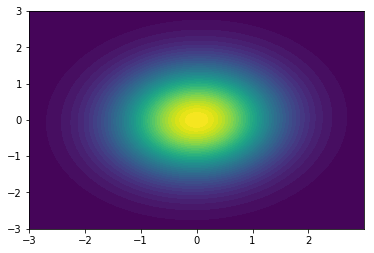

In [44]:
from scipy.stats import multivariate_normal
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.zeros(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal([0, 0], matrices[0]) #matrices[5] 
plt.contourf(x, y, rv.pdf(pos), 50)

In [10]:
#%%timeit
#We time making the subcatalogs
#images =[]
#rband = truth_table['LMAG'][:,1] #grizy
#te1 = truth_table['TE'][:,0]
#te2 = truth_table['TE'][:,1]
#ra, dec, tsize, elip1, elip2, lmag, gflux = ([] for i in range(7))
#for i in range(0, 1000):
#    ra = cat.get(i, 'RA')
#    dec = cat.get(i, 'DEC')
#    tsize = cat.get(i, 'TSIZE')

#    elip1 = te1[i]
#    elip2 = te2[i]
#    lmag = rband[i]

#    gflux = 10**((lmag-22.5)/-2.5)
#    gal = galsim.Gaussian(flux=gflux, half_light_radius=tsize)
#    gal = gal.shear(e1=elip1, e2=elip2)
#    _foo = galsim.Shear(e1=elip1, e2=elip2)
#    matrix = _foo.getMatrix()

In [11]:
#%%timeit
#for i in range(0, 1000):
#    gal = galsim.Gaussian(flux=gflux, half_light_radius=tsize)
#    gal = gal.shear(e1=elip1, e2=elip2)
#    image = galsim.ImageF(100, 100)
#    final = galsim.Convolve([gal])
#    final.drawImage(image, scale =0.2)
#    images.append(image)
    
#galsim.fits.writeMulti(images, file_name)

In [12]:
from astropy.utils.data import get_pkg_data_filename
image_file = get_pkg_data_filename('/afs/slac.stanford.edu/u/ki/gwisk/CRNProject/multi.fits')

<Figure size 432x288 with 0 Axes>

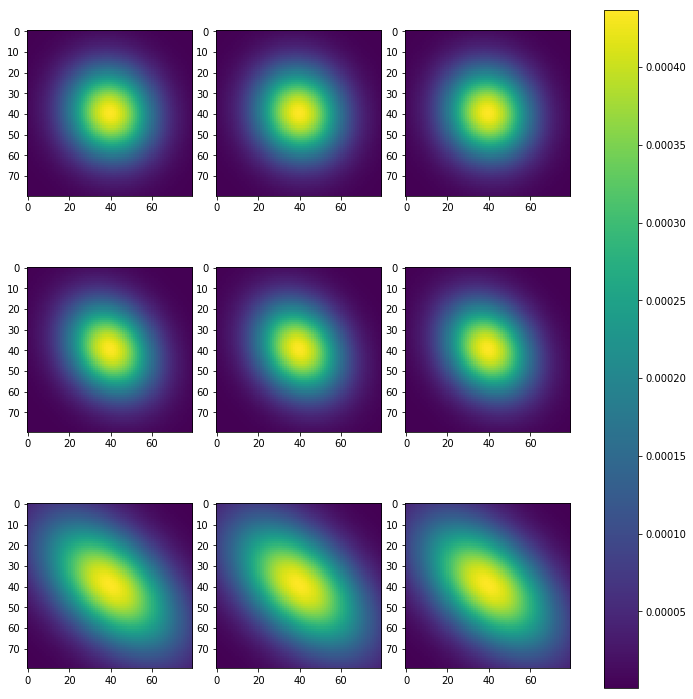

<Figure size 432x288 with 0 Axes>

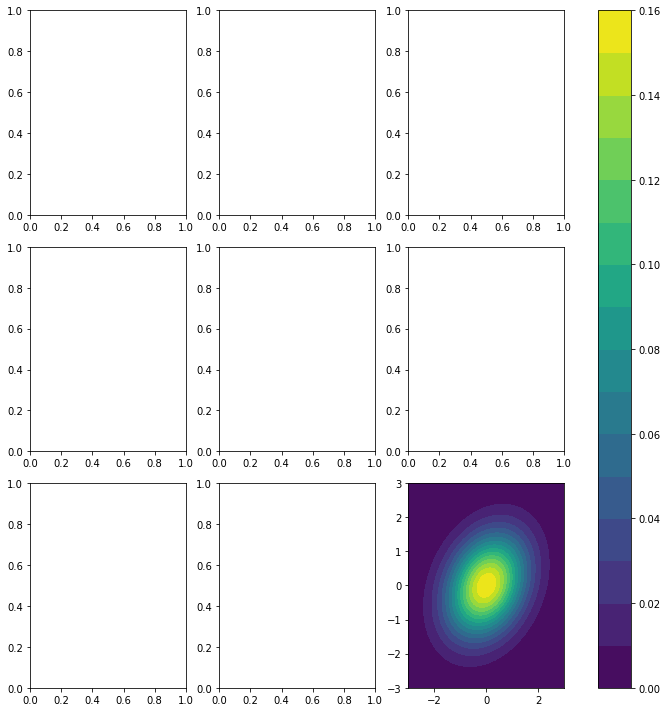

In [48]:
plt.figure()
f, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        image_data = fits.getdata(image_file, ext = i)
        im = ax[i, j].imshow(image_data)

plt.tight_layout()
plt.colorbar(im, ax=ax)


plt.figure()
f, ax = plt.subplots(3, 3, figsize=(10, 10))
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.zeros(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
    
for i in range(3):
    for j in range (3):
        rv = multivariate_normal([0, 0], matrices[i+j])
        im = plt.contourf(x, y, rv.pdf(pos), 15)
plt.tight_layout()
plt.colorbar(im, ax=ax)